In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download dansbecker/cityscapes-image-pairs

In [ ]:
! unzip cityscapes-image-pairs.zip

In [ ]:
import numpy as np
import pandas as pd
import os

!pip install torchviz
%matplotlib inline
import cv2
import random
import tqdm
from tqdm import notebook
import matplotlib.pyplot as plt

import torch
from PIL import Image
import torch.nn as nn


In [ ]:
import torch
from torch import nn
import torchvision
from torchviz import make_dot

import segmentation_models_pytorch as seg_models

In [ ]:
!pip install segmentation-models-pytorch

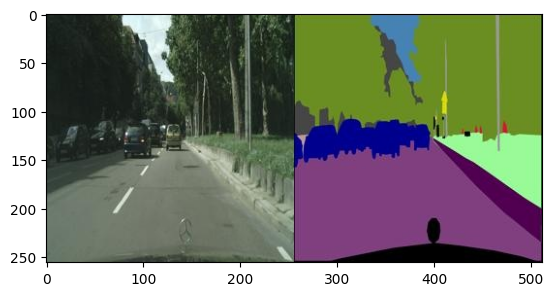

In [ ]:
image_dir = "./cityscapes_data"
train_images = os.path.join(image_dir, 'train')
val_images = os.path.join(image_dir, 'val')

train_files = os.listdir(train_images)
val_files = os.listdir(val_images)

# Print any image of your choice from the training set
s_no = 20

img = Image.open(os.path.join(train_images, train_files[s_no])).convert("RGB")

plt.imshow(img)
plt.show()

In [ ]:
class data_load(object):
    def __init__(self, images_dir, batch_size, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(data_load, self).__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.target_size = target_size
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.step_number = 0
        self.total_steps = int(len(self.filenames) // self.batch_size)

    def generate_batch(self):
        start = self.step_number * self.batch_size
        stop = (self.step_number + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]

        images_batch = [cv2.imread(filename) for filename in filenames_batch]
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])

        # To separate images and their labels
        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch])

        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        images_batch /= self.rescale
        images_batch = np.moveaxis(images_batch, 1, 0)

        return torch.Tensor(images_batch)

    def __next__(self):
        if self.step_number > self.total_steps:
            self.step_number = 0
        images, masks = self.generate_batch()
        self.step_number += 1
        return images, masks

    def __len__(self):
        return self.total_steps

In [ ]:
def dice(pred, label):
    pred = (pred > 0).float()
    return 2. * (pred*label).sum() / (pred+label).sum()

In [ ]:
import torch.nn as nn
import torch
import math
import torch.utils.model_zoo as model_zoo
from torchvision.ops import nms
from retinanet.utils import BasicBlock, Bottleneck, BBoxTransform, ClipBoxes
from retinanet.anchors import Anchors
from retinanet import losses

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


class PyramidFeatures(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(PyramidFeatures, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)

        return [P3_x, P4_x, P5_x, P6_x, P7_x]


class RegressionModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)

        # out is B x C x W x H, with C = 4*num_anchors
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 4)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        out = self.output_act(out)

        # out is B x C x W x H, with C = n_classes + n_anchors
        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, channels = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchors, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)


class ResNet(nn.Module):

    def __init__(self, num_classes, block, layers):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        if block == BasicBlock:
            fpn_sizes = [self.layer2[layers[1] - 1].conv2.out_channels, self.layer3[layers[2] - 1].conv2.out_channels,
                         self.layer4[layers[3] - 1].conv2.out_channels]
        elif block == Bottleneck:
            fpn_sizes = [self.layer2[layers[1] - 1].conv3.out_channels, self.layer3[layers[2] - 1].conv3.out_channels,
                         self.layer4[layers[3] - 1].conv3.out_channels]
        else:
            raise ValueError(f"Block type {block} not understood")

        self.fpn = PyramidFeatures(fpn_sizes[0], fpn_sizes[1], fpn_sizes[2])

        self.regressionModel = RegressionModel(256)
        self.classificationModel = ClassificationModel(256, num_classes=num_classes)

        self.anchors = Anchors()

        self.regressBoxes = BBoxTransform()

        self.clipBoxes = ClipBoxes()

        self.focalLoss = losses.FocalLoss()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classificationModel.output.weight.data.fill_(0)
        self.classificationModel.output.bias.data.fill_(-math.log((1.0 - prior) / prior))

        self.regressionModel.output.weight.data.fill_(0)
        self.regressionModel.output.bias.data.fill_(0)

        self.freeze_bn()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def forward(self, inputs):

        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs

        x = self.conv1(img_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        features = self.fpn([x2, x3, x4])

        regression = torch.cat([self.regressionModel(feature) for feature in features], dim=1)

        classification = torch.cat([self.classificationModel(feature) for feature in features], dim=1)

        anchors = self.anchors(img_batch)

        if self.training:
            return self.focalLoss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            finalResult = [[], [], []]

            finalScores = torch.Tensor([])
            finalAnchorBoxesIndexes = torch.Tensor([]).long()
            finalAnchorBoxesCoordinates = torch.Tensor([])

            if torch.cuda.is_available():
                finalScores = finalScores.cuda()
                finalAnchorBoxesIndexes = finalAnchorBoxesIndexes.cuda()
                finalAnchorBoxesCoordinates = finalAnchorBoxesCoordinates.cuda()

            for i in range(classification.shape[2]):
                scores = torch.squeeze(classification[:, :, i])
                scores_over_thresh = (scores > 0.05)
                if scores_over_thresh.sum() == 0:
                    # no boxes to NMS, just continue
                    continue

                scores = scores[scores_over_thresh]
                anchorBoxes = torch.squeeze(transformed_anchors)
                anchorBoxes = anchorBoxes[scores_over_thresh]
                anchors_nms_idx = nms(anchorBoxes, scores, 0.5)

                finalResult[0].extend(scores[anchors_nms_idx])
                finalResult[1].extend(torch.tensor([i] * anchors_nms_idx.shape[0]))
                finalResult[2].extend(anchorBoxes[anchors_nms_idx])

                finalScores = torch.cat((finalScores, scores[anchors_nms_idx]))
                finalAnchorBoxesIndexesValue = torch.tensor([i] * anchors_nms_idx.shape[0])
                if torch.cuda.is_available():
                    finalAnchorBoxesIndexesValue = finalAnchorBoxesIndexesValue.cuda()

                finalAnchorBoxesIndexes = torch.cat((finalAnchorBoxesIndexes, finalAnchorBoxesIndexesValue))
                finalAnchorBoxesCoordinates = torch.cat((finalAnchorBoxesCoordinates, anchorBoxes[anchors_nms_idx]))

            return [finalScores, finalAnchorBoxesIndexes, finalAnchorBoxesCoordinates]



def resnet18(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18'], model_dir='.'), strict=False)
    return model


def resnet34(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34'], model_dir='.'), strict=False)
    return model


def resnet50(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50'], model_dir='.'), strict=False)
    return model


def resnet101(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101'], model_dir='.'), strict=False)
    return model


def resnet152(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152'], model_dir='.'), strict=False)
    return model